# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile

from PIL import Image
from PIL import ImageDraw
import pytesseract
import cv2 as cv
import numpy as np

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# the rest is up to you!
# create global data structure to store PIL images, texts, bounding boxes etc.
page = [] # a list of dictionaries about all data corresponding to a page

In [2]:
def store_pages(file, page):
    # read small_img.zip into a zip list
    zf = zipfile.ZipFile(file, 'r')
    zf_lst = zf.infolist()

    for entry in zf_lst:
        news_file = zf.open(entry)  
        img = Image.open(news_file)
        page_dict = {}
        page_dict['page_name'] = entry.filename
        page_dict['PIL_img'] = img
        page_dict['page_text'] = pytesseract.image_to_string(img).split()
        open_cv_image = np.array(img)
        gray = cv.cvtColor(open_cv_image, cv.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,2)
        page_dict['bbox'] = faces.tolist()
        page.append(page_dict)
    return page

In [3]:
def contact_sheet_size(faces):
    """return contact sheet size with a tuple(width, height) according to the faces list"""
    if faces%5 == 0:
        return (900, (faces//5)*180)
    return (900, (faces//5+1)*180)

In [4]:
def page_with_word(page, word):
    """return a list of pages index that has word in it"""
    page_with_word = []
    for idx in range(len(page)):
        if word in page[idx]['page_text']:
            page_with_word.append(idx)
    return page_with_word

In [5]:
def crop_faces_list(single_page):
    """return a list of cropped faces from one page"""
    crop_lst = []
    for f in single_page['bbox']:
        crop_image = single_page['PIL_img'].crop((f[0],f[1],f[0]+f[2],f[1]+f[3]))
        crop_lst.append(crop_image.resize((180, 180)))
    return crop_lst

In [6]:
def combo_search(page, word):
    """return a contact sheet with cropped faces from pages with word. and display them"""
    for p in page:
        for long_word in p['page_text']:
            if word in long_word:
                print("Results found in file {}".format(p['page_name']))
                if p['bbox'] == []:
                    print("But there were no faces in that file!")
                    break
                else: #crop faces and create contact sheet
                    contact_sheet=Image.new("RGB", contact_sheet_size(len(p["bbox"])))
                    faces = crop_faces_list(p)
                    x, y = 0, 0
                    for img in faces:
                        contact_sheet.paste(img, (x,y))
                        if x+180 == contact_sheet.width:
                            x=0
                            y=y+180
                        else:
                            x=x+180
                    display(contact_sheet)
                    break

Results found in file a-0.png


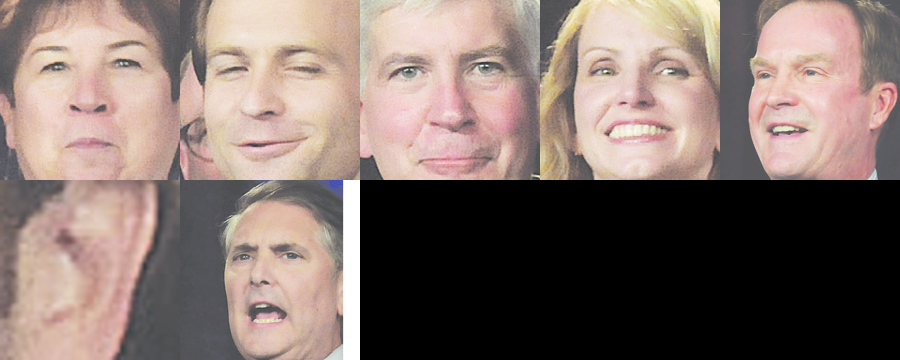

Results found in file a-3.png


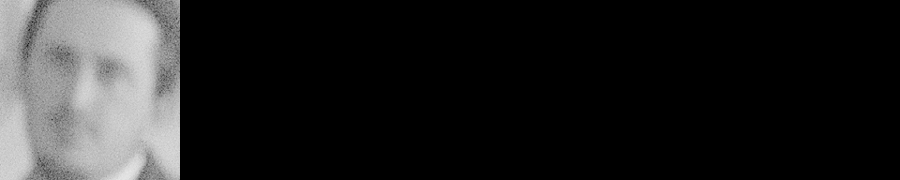

In [7]:
page = store_pages('readonly/small_img.zip', page)
combo_search(page, "Chris")